# Enhancement

## 1. Retrieve Data from MongoDB
Retreive all documents from MongoDB and convrt it to a `pandas.DataFrame`

In [65]:
import pandas as pds
sql = """
SELECT indicator, AVG(value) as mean
FROM `worlddev.wdi.main`
WHERE country_code = @country_code
GROUP BY indicator
"""

def config(country_code):
    query_config = {
        'query': {
            'parameterMode': 'NAMED',
            'queryParameters': [
                {
                    'name': 'country_code',
                    'parameterType': {'type': 'STRING'},
                    'parameterValue': {'value': country_code}
                }
            ]
        }
    }
    return query_config

# Run a Standard SQL query with the project set explicitly
project_id = 'worlddev'

def get_data(country_code):
    df = pds.read_gbq(sql, configuration=config(country_code), project_id=project_id)
    return df

In [66]:
wld = get_data('WLD')
chn = get_data('CHN')
usa = get_data('USA')
bra = get_data('BRA')

Downloading: 100%|██████████| 416/416 [00:00<00:00, 2084.13rows/s]


In [67]:
usa

,indicator,mean
0,Access to clean fuels and technologies for coo...,1.000000e+02
1,Access to electricity,1.000000e+02
2,Account ownership at a financial institution o...,8.382918e+01
3,Adjusted net enrollment rate,9.705572e+01
4,Adjusted net national income,8.922813e+12
...,...,...
373,Urban population growth,1.321498e+00
374,Urban population living in areas where elevati...,2.279562e+00
375,Vulnerable employment,3.856621e+00
376,Wage and salaried workers,9.403452e+01


# TensorFlow model to model each country as an embedding vector

This process is to prelimiarily compare a developed country, a developing country, and a vague country. We bring in all the cleaned up indicators, and create a clustering by creating embedding vectors based on these values, normalize them, and conduct PCA to draw them on a plot. We can clearly see that USA is faraway from the World average, and Brazil and China are pretty similar to each other. 

In [82]:
merge1 = pds.merge(wld, chn, on='indicator', how='inner')
merge1 = merge1.rename(columns={"mean_x": "wld", "mean_y": "chn"})
merge2 = pds.merge(usa, bra, on='indicator', how='inner')
merge2 = merge2.rename(columns={"mean_x": "usa", "mean_y": "bra"})
embeddings = pds.merge(merge1, merge2, on='indicator', how='inner')
embeddings = embeddings.drop(['indicator'], axis=1)
embeddings = np.transpose(embeddings.to_numpy())
embeddings

array([[ 54.61707757,  67.89113068,  52.16160456, ...,  51.10279134,
         47.42107992,  19.54766922],
       [ 53.25176471,  96.15677797,  62.51767095, ...,  58.65872409,
         39.99658617,   5.61005995],
       [100.        , 100.        ,  83.82917531, ...,   3.85662069,
         94.03451696,  24.86203563],
       [ 92.19882353,  82.78662927,  50.46011225, ...,  28.21813794,
         69.19782757,  30.26601334]])

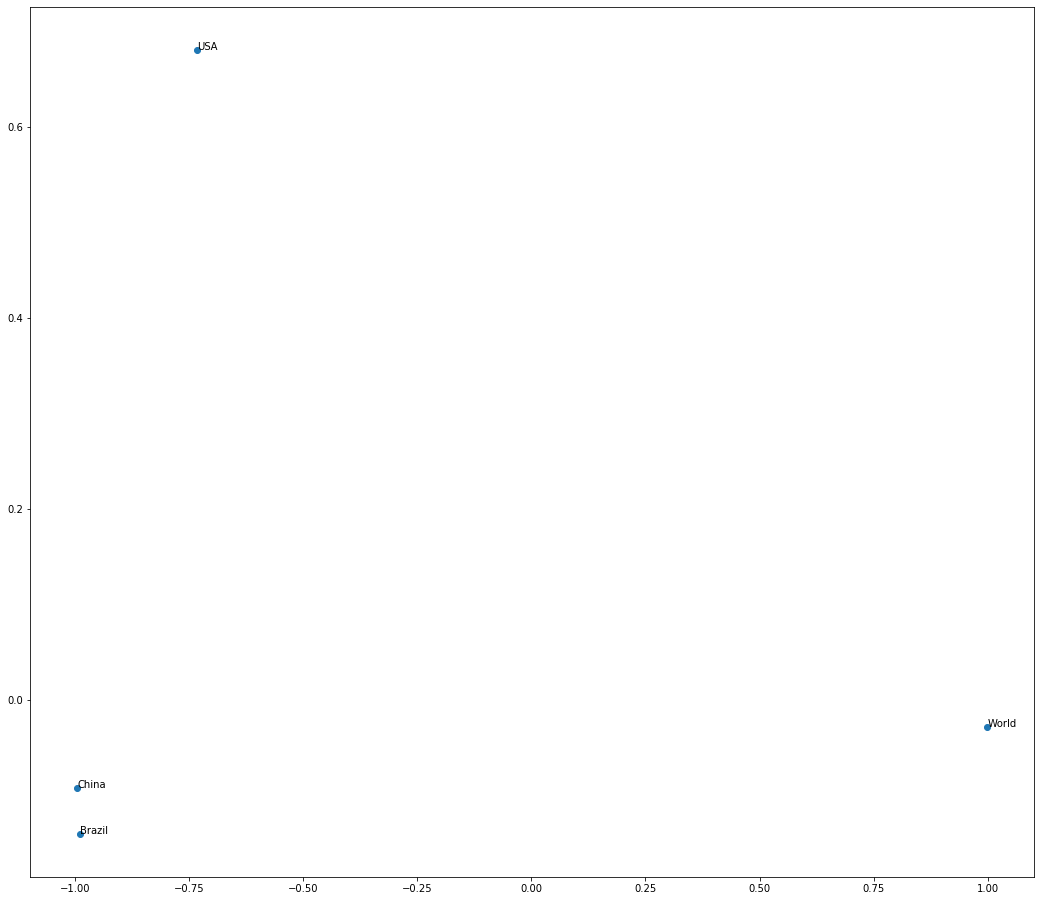

In [83]:
# Visualizing the Embeddings
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# reduce dimenion from 30 to 2
pca = PCA(n_components=2) # PCA is better than TSNE for large dimension like 30 :)

vectors = pca.fit_transform(np.array(embeddings))

# normalize the results so that we can view them more comfortably in matplotlib
normalizer = preprocessing.Normalizer()
norm_vectors = normalizer.fit_transform(vectors, 'l2')

# plot the 2D normalized vectors
x_vec = []
y_vec = []
for x,y in norm_vectors:
  x_vec.append(x)
  y_vec.append(y)
  
f, axs = plt.subplots(1,1,figsize=(18,16))
plt.scatter(x_vec, y_vec)
countries = ['World', 'China', 'USA', 'Brazil']
for i in range(len(countries)):
      plt.annotate(countries[i], (x_vec[i], y_vec[i]))
plt.show()

The actual website will c